In [36]:
import pandas as pd
import os
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_lqe_model
from optimizers.utils._utils import get_csv_data
from optimizers.cross_validators import vbt_cv_sliding_constructor
from research.pipes.sql import SQLPipe
from research.utils import kalmanfilter

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'bihourly'
FREQ = '30T'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, FREQ)

In [37]:
assets = ['THETA-USDT', 'FIL-USDT']
slicer = -25000 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

n = 3
train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=n)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=n)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 25000
Test data length: 7500
Train fold length 5833


In [54]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70 2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN) <- this might be fixed now
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?
# XLM SUN / SUN XLM  does not generalize well. Low trade count, high duration
# XMR ETH failed across all models. Still need to test ETH XMR
# ASX VRA DEFAULT 20 2.0 -1.8 0.6 8e-8 1.2 <- extremely successful 1hour
# DOGE SUN / SUN DOGEfailed on all models
# FIL CAKE DEFAULT 510 1.6 -1.4 0.1 6e-6 7e-1 returned low trade count, high duration, but ~2 sharpe, high wr, high pr. Bears live testing
# THETA FIL LOG 355 1.5 -1.5 1.2 1E-9 0.15 works quite well at 20bps slippage. Fat tail risk in trades leads to low sharpe
# EOS CAKE does not work on any metric; XMR CAKE LOG failed
# SHIB DOGE / DOGE SHIB 30MIN LOG RET & LOG model failed to generalize
# THETA FIL LOG BETA 845 0.9 -1.6 0.8 8e-9 1.6 30MIN <- high sharpe / 410 0.6 -2.7 0.2 6e-9 1.8 30MIN <- lower sharpe
# AXS VRA 920 2.7 -2.4 0.8 1e-9 1.3-8 LOG 30M BETA <- high freq ~2x sharpe DEPLOY TO LIVE TEST // Results in NEGATIVE beta...
# THETA FIL LOG 860 0.9 -3.7 0.8 3e-9 0.11 30MIN BETA <- ~3 sharpe, decent trade rate. Primarily driven by two positive outliers

PERIOD = 860
UPPER = 0.9
LOWER = -3.7
EXIT = 0.8
DELTA = 4e-9
VT = 1.8e-1
BURNIN = 600
MODEL = 'log'
HEDGE = 'beta'
SLIPPAGE = 0.0010
SIZE = 0.10

In [55]:
pf = simulate_lqe_model(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    transformation=MODEL,
    slippage=SLIPPAGE,
    order_size=SIZE,
)

0.036230299907159515


<AxesSubplot:>

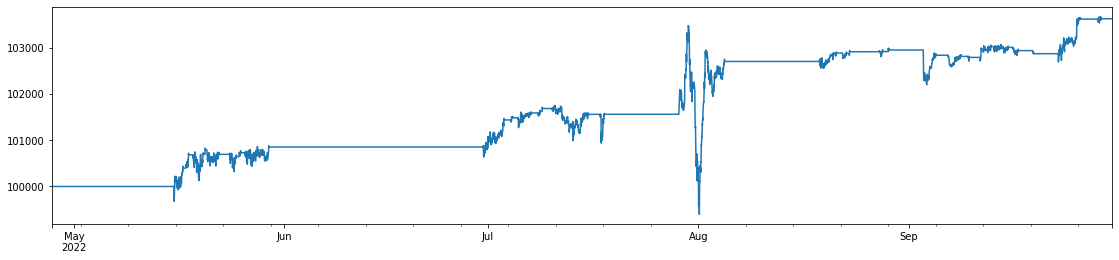

In [56]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [57]:
pnl = (pf.trades.records_readable.groupby('Entry Timestamp').sum().PnL.resample('D').sum())
val = pf.value().resample('D').asfreq().fillna(pf.value())
res = pd.concat([pnl, val], axis=1, keys=['pnl', 'val'])
res = res.fillna(0)
res['ret'] = res.pnl / res.val
Rf = (1 + 0) ** (1/365) - 1 # Daily risk free rate
Rp = res.ret.mean() # Daily portfolio return
STDp = res.ret.std() # Daily standard deviation of return
sharpe = ((Rp - 0) / STDp) * np.sqrt(365) # Annualized sharpe

In [58]:
trade_df = pf.trades.records_readable.sort_values('Entry Timestamp')
g = trade_df.groupby('Entry Timestamp')
net_trades = g.sum()
n = g.first().reset_index()
dur = (n['Exit Timestamp'] - n['Entry Timestamp']).dt.total_seconds()/(60*60) # Trade durations in hours
dur.index = n['Entry Timestamp']
net_trades['duration'] = dur

print(f"Total trades: {net_trades.shape[0]}")
print(f"Net long-short win rate: {net_trades.PnL[net_trades.PnL > 0].shape[0] / net_trades.shape[0] * 100:.2f}%")
print(f"Sharpe ratio: {sharpe:.4f}")
print(f"Profit Ratio: {net_trades.PnL[net_trades.PnL > 0].mean() / np.abs(net_trades.PnL[net_trades.PnL < 0].mean()):.3f}")
print(f"Mean trade profit: {net_trades.PnL.mean():.2f} +/- {net_trades.PnL.std():.2f}")
print(f"Median trade profit: {net_trades.PnL.median():.2f}")
print(f"Duration [hours]: {net_trades.duration.mean():.2f} +/- {net_trades.duration.std():.2f}")

Total trades: 78
Net long-short win rate: 62.82%
Sharpe ratio: 2.7537
Profit Ratio: 1.857
Mean trade profit: 46.45 +/- 230.51
Median trade profit: 12.02
Duration [hours]: 12.54 +/- 18.30


<AxesSubplot:xlabel='Entry Timestamp'>

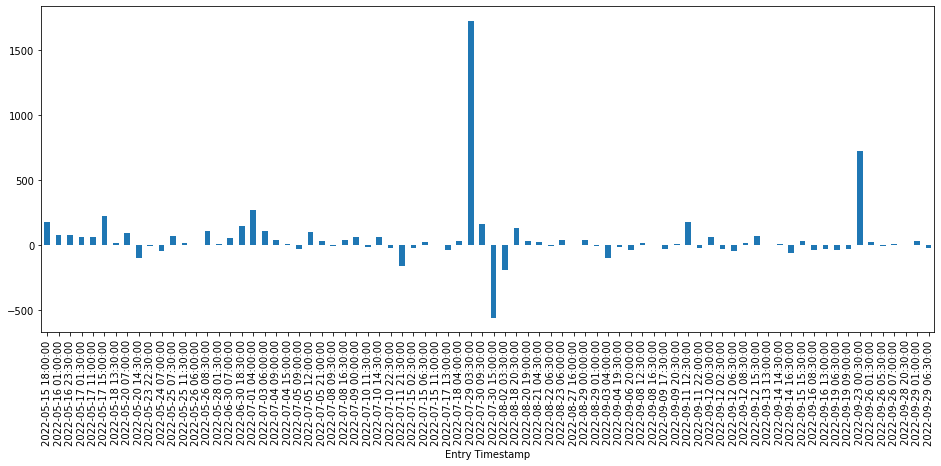

In [59]:
net_trades.PnL.plot(kind="bar", figsize=(16,6))

Kurtosis: 38.59997234009773
Skew: 5.123304824724175


<AxesSubplot:ylabel='Frequency'>

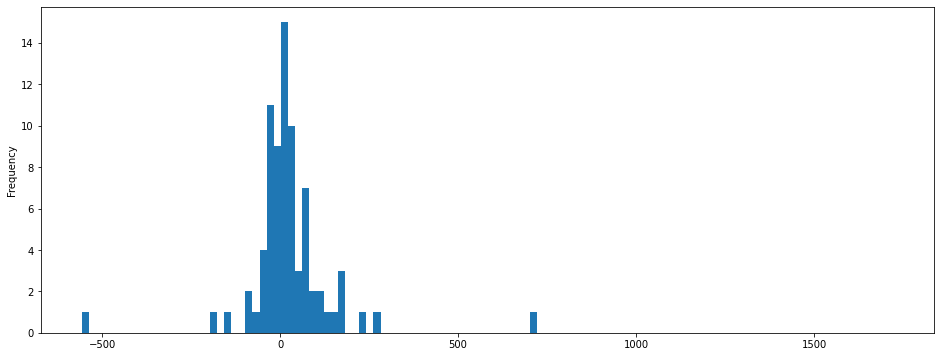

In [60]:
print(f'Kurtosis: {kurtosis(net_trades.PnL, fisher=False)}')
print(f'Skew: {skew(net_trades.PnL)}')

bins = np.arange(net_trades.PnL.min(), net_trades.PnL.max(), 20)
net_trades.PnL.plot(kind="hist", figsize=(16,6), bins=bins)

<AxesSubplot:>

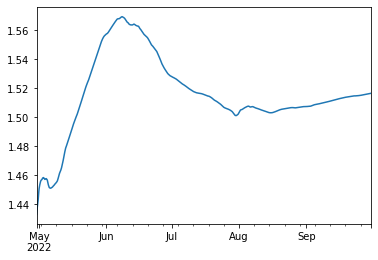

In [61]:
if MODEL == 'log':
    data = np.log(closes)
elif MODEL == 'logret':
    data = np.log1p(closes.pct_change()).dropna()
elif MODEL == 'cumlog':
    data = np.log1p(closes.pct_change()).cumsum().dropna()
res = kalmanfilter(data, DELTA, VT, export_df=True)[100:]

trade_df = pf.trades.records_readable.sort_values('Entry Timestamp')
g = trade_df.groupby('Entry Timestamp')
x, y = assets
betas = []

for idx, gr in g:
    sign = -1 if gr.Direction.nunique() == 1 else 1
    xv = gr[gr['Column'] == x]
    yv = gr[gr['Column'] == y]
    xval = xv['Size'] * xv['Avg Entry Price']
    yval = yv['Size'] * yv['Avg Entry Price']
    beta = (xval.values / yval.values) * sign
    betas.append(beta)

betas = np.vstack(betas).flatten()
ser = pd.Series(betas, index=trade_df['Entry Timestamp'].unique(), name='beta')

res.slope.plot()